## Spatial CRM demo with synthetic data

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.optim import Adam

sys.path.append('..')
from src import (SpatialCRM, coords_scaling, get_intersection_period, make_data, to_tensors,
                 get_statistics, show_well, train_model, show_predictions, show_fields)
from src.crm_models import calc_rate

### Set synthetic well parameters

In [2]:
params = pd.DataFrame(dict(tau=[1.8, 2.2, .5, .5],
                           J=[.4, .2, .2, .4],
                           f=[1.2, .8, 2.0, .4]))
params

,tau,J,f
0,1.8,0.4,1.2
1,2.2,0.2,0.8
2,0.5,0.2,2.0
3,0.5,0.4,0.4


### Set synthetic well schedule

In [3]:
t = torch.linspace(0, 1, 100)

pres = torch.tensor([[6]*30 + [10]*20 + [2]*40 + [7]*10,
                     [2]*10 + [5]*70 + [9]*20,
                     [10]*40 + [4]*20 + [8]*40,
                     [7]*60 + [5]*10 + [1]*30])

inject = torch.ones_like(t)
inject[20:70] = 8

q0 = [10, 6, 4, 8]

### Calculate production rates using the CRM equation

In [4]:
q = np.vstack([calc_rate(t.reshape(1, -1),
                         p.diff().reshape(1, -1),
                         inject.reshape(1, -1), *prm, q) for
               p, prm, q in zip(pres, params.values, q0)])

### Write synthetic data

In [5]:
dates = pd.date_range('2010-01-01', '2020-01-01', freq='MS')[:len(t)]

prod = pd.concat([pd.DataFrame({'cat': 'well_{}'.format(i+1),
                                'date': dates,
                                'liquid': q[i],
                                'bhp': pres[i],
                                'group': 'P'}) for i in range(4)])
inj = pd.DataFrame({'cat': 'inj',
                    'date': dates,
                    'water_inj': inject,
                    'group': 'I'})

pd.concat([prod, inj]).to_csv('data/data_synt.csv', index=False)

### Write synthetic coordinates

In [6]:
coords = np.array([[0, 0], [0, 1], [1, 1], [1, 0]])
pd.DataFrame({'cat': ['well_{}'.format(i+1) for i in range(4)],
              'x': coords[:, 0],
              'y': coords[:, 1],
              'group': 'P'}).to_csv('data/coords_synt.csv', index=False)

### Read production data

In [7]:
df = pd.read_csv('data/data_synt.csv')
df.date = pd.to_datetime(df.date)
df.head()

,cat,date,liquid,bhp,group,water_inj
0,well_1,2010-01-01,10.000000,6.0,P,NaN
1,well_1,2010-02-01,9.950774,6.0,P,NaN
2,well_1,2010-03-01,9.901824,6.0,P,NaN
3,well_1,2010-04-01,9.853148,6.0,P,NaN
4,well_1,2010-05-01,9.804744,6.0,P,NaN


### Read and scale coordinates

In [8]:
coords = pd.read_csv('data/coords_synt.csv')
coords = coords_scaling(coords).set_index('cat')
coords.head()

,x,y,group,xn,yn
cat,,,,,
well_1,0,0,P,0.0,0.0
well_2,0,1,P,0.0,1.0
well_3,1,1,P,1.0,1.0
well_4,1,0,P,1.0,0.0


### Show well's locations 

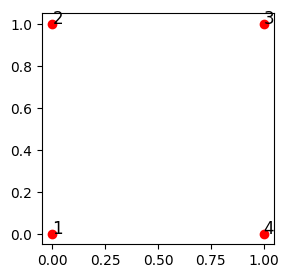

In [9]:
fig, ax = plt.subplots(1, figsize=(3, 3))
plt.scatter(*coords.loc[coords.group == 'P', ['xn', 'yn']].values.T, c='r')
coords.apply(lambda x: plt.text(x.xn, x.yn, x.name.split('_')[1], fontdict={'fontsize': 12}), axis=1)
plt.show()

### Get the start and end date of the common production time period

In [10]:
dmin, dmax = get_intersection_period(df)
dmin, dmax

(datetime.date(2010, 1, 1), datetime.date(2018, 4, 1))

### Organize production date

In [11]:
wells_data = make_data(df, dmin=dmin, dmax=dmax)

### Get statistics for data normalization

In [12]:
stats = get_statistics(wells_data)
stats

{'mean_rate': 6.8082903749999995, 'mean_pres': 5.95, 'mean_inj': 4.5}

### Show sample data

In [13]:
show_well(wells_data)

interactive(children=(Dropdown(description='Well:', options=(('well_1', 'well_1'), ('well_2', 'well_2'), ('wel…

### Prepare torch tensors

In [14]:
test_start = pd.to_datetime('2016-01-01')
train_ds = to_tensors(wells_data, coords, stats, test_start)

### Init CRM model

In [15]:
model = SpatialCRM(h=10, tau_min=0.1, J_min=0.1, f_min=0.1)
optimizer = Adam(model.parameters(), lr=0.01, weight_decay=0.000)
loss_hist = []

### Train model

In [16]:
lh = train_model(model, n_iters=3000, dataset=train_ds, optimizer=optimizer)
loss_hist.extend(lh)

100%|█████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 452.49it/s]


### Show loss

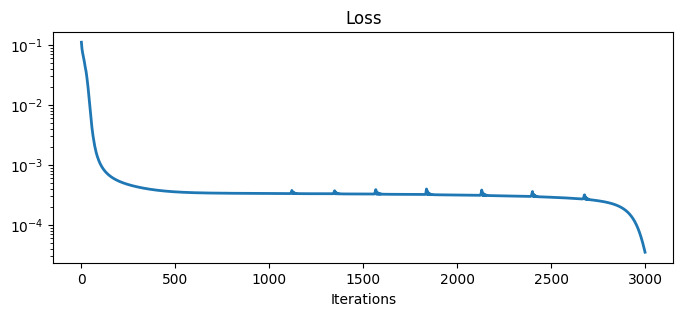

In [17]:
fig = plt.figure(figsize=(8, 3))
fig.patch.set_facecolor('xkcd:white')
plt.semilogy(np.array(loss_hist), lw=2)
plt.title('Loss')
plt.xlabel('Iterations')
plt.show()

### Show fields

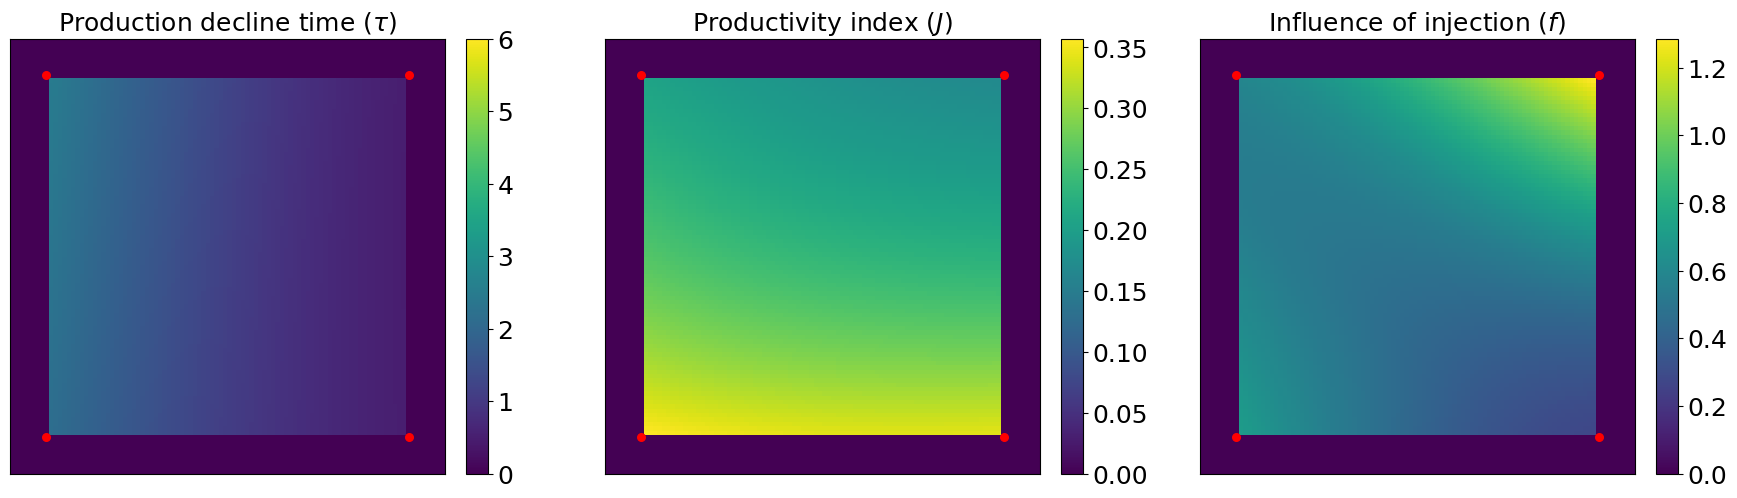

In [18]:
x = y = np.linspace(-0.1, 1.1, 100)

show_fields(model, coords, x, y, show_names=False, figsize=(18, 5))

### Show predictions

In [19]:
show_predictions(model=model, dataset=train_ds, test_start=test_start)

interactive(children=(Dropdown(description='Well:', options=(('well_1', 'well_1'), ('well_2', 'well_2'), ('wel…

### Conpare estimated and true well parameters

In [20]:
locs = torch.tensor(coords[['xn', 'yn']].values).float()
pd.DataFrame(dict(well_id=coords.index,
                  tau_true=params.tau.values,
                  tau_pred=list(model.tau(locs).detach().numpy().ravel().round(2)),
                  J_true=params.J.values,
                  J_pred=list(model.J(locs).detach().numpy().ravel().round(2)),
                  f_true=params.f.values,
                  f_pred=list(model.f(locs).detach().numpy().ravel().round(2))))

,well_id,tau_true,tau_pred,J_true,J_pred,f_true,f_pred
0,well_1,1.8,2.18,0.4,0.36,1.2,0.72
1,well_2,2.2,2.51,0.2,0.21,0.8,0.59
2,well_3,0.5,0.49,0.2,0.17,2.0,1.31
3,well_4,0.5,0.49,0.4,0.34,0.4,0.27


Done!